In [1]:
import os 
os.chdir('/Users/marcs')

In [2]:
from pickle_loader import pickle_loader


In [3]:
LSTM_dataset = technical_data = pickle_loader('/Users/marcs/OneDrive/Documents/stock_analysis2/standardised_LSTM_data.pickle')

### Flatten the data

The LSTM data is currently grouped by stock. Each stock has  tuple with a list of array containing sequences for the given stock on element 0, and a list of the corresponding target variables on element 1. For module consumption a 1 dimensional list of sequences and target varibles is needed 

In [4]:
def flatten_dataset(LSTM_dataset):
    X = []
    y = []
    
    for stock_data in LSTM_dataset:
        for quarter_data_X in stock_data[0]:
            X.append(quarter_data_X)
        for quarter_data_y in stock_data[1]:
            y.append(quarter_data_y)
        
    return X, y

In [5]:
X_data, y_data = flatten_dataset(list(LSTM_dataset.values()))

In [6]:
len(X_data)

1488

In [7]:
len(y_data)

1488

In [8]:
X_data[0].shape

(124, 5)

### Get test train split 

The sklearn train_test_split function will be used to obatain a randomised splt of the dataset 
to generate a train and test dataset. The size of the train set will be the multiple of 8 closest to 80% of the entire datset. A multiple of 8 is used as batches of size 8 will be used to train the model.

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
def split_dataset(X, y, split = 0.8):
    num_samples = len(X)
    train_size = int(num_samples * split)  - (int(num_samples * split) % 8)
    return train_test_split(X, y, train_size = train_size, random_state = 211)

X_train, X_test, y_train, y_test = split_dataset(X_data, y_data)

print('Size of X_train, X_test, y_train, y_test are:', len(X_train), len(X_test), len(y_train), len(y_test))

Size of X_train, X_test, y_train, y_test are: 1184 304 1184 304


### Split the samples of the train and test set into batches
The train set will be a list of array's of size (8, len_seq, 5) 

The test set will be a list of array's of size (len_test_set, len_seq, 5)


In [43]:
import numpy as np
def batch_train_test(X_train, X_test, y_train, y_test, train_batch_size = 16):
    num_train_batches = len(X_train) / 8
    seq_len, num_features = X_train[0].shape
    
    batched_X_train = []
    batched_y_train = []
    for i in range(0, len(X_train), train_batch_size):
        batched_X_train.append(np.stack(X_train[i : (i + train_batch_size)], dtype = np.float32))
        batched_y_train.append(np.reshape(np.array(y_train[i : (i + train_batch_size)], dtype = np.float32), (train_batch_size, 1)))
    print(batched_X_train[0].shape, batched_y_train[0].shape)
    
    batched_X_test = np.stack(X_test, dtype = np.float32)
    batched_y_test = np.array(y_test, dtype = np.float32)
    print(batched_X_test.shape, batched_y_test.shape)
    
    return batched_X_train, batched_X_test, batched_y_train, batched_y_test
    
batched_X_train, batched_X_test, batched_y_train, batched_y_test = batch_train_test(X_train, X_test, y_train, y_test)

(16, 124, 5) (16, 1)
(304, 124, 5) (304,)


### Create tensors 

In [44]:
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable

In [45]:
X_train_tensor = [torch.from_numpy(arr) for arr in batched_X_train]
X_test_tensor = torch.from_numpy(batched_X_test)
y_train_tensor = [torch.from_numpy(arr) for arr in batched_y_train]
y_test_tensor = torch.from_numpy(batched_y_test)
print(X_train_tensor[0].shape, X_test_tensor.shape, y_train_tensor[0].shape, y_test_tensor.shape)

torch.Size([16, 124, 5]) torch.Size([304, 124, 5]) torch.Size([16, 1]) torch.Size([304])


### Define Model

In [67]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_length, dropout_pr):
        super(LSTM, self).__init__()
        
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 = nn.Linear(hidden_size * num_layers, hidden_size) #fully connected 1
        self.fc_2 = nn.Linear(hidden_size, hidden_size) #fully connected 2
        self.dropout = nn.Dropout(dropout_pr) # add a droput layer 
        self.fc = nn.Linear(hidden_size, 1) #fully connected last layer
        self.relu = nn.ReLU()
        
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        h_0, c_0 = h_0.to(device, non_blocking = True), c_0.to(device, non_blocking = True)
        # Propagate input through LSTM
        out, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state

        out = hn.view(-1, self.hidden_size * self.num_layers) #reshaping the data for Dense layer next
        out = self.relu(out)

        out = self.fc_1(out) # first Dense
        out = self.relu(out) # relu
        out = self.dropout(out)
        
        out = self.fc_2(out) # second dense
        out = self.relu(out) # relu
        out = self.dropout(out)
        
        out = self.fc(out) #Final Output
        return out

In [47]:
#First reinalitialse the model
learning_rate = 0.001 #0.001 lr

input_size = 5 #number of features
hidden_size = 150 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes

print(X_train_tensor[0].shape[2])
lstm1 = LSTM(X_train_tensor[0].shape[2], hidden_size, num_layers, X_train_tensor[0].shape[1], 0.2)
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)
    
previous_loss = 100000 # intialise previous loss as large 
torch.manual_seed(16) # set seed to get reproducibility of results

outputs = lstm1.forward(X_train_tensor[0]) #forward pass
print(outputs.shape)
optimizer.zero_grad() #caluclate the gradient, manually setting to 0
        
# obtain the loss function
loss = criterion(outputs, y_train_tensor[0])

loss.backward() #calculates the loss of the loss function
 
optimizer.step() #improve from loss, i.e backprop

5
The hidden size is 150
torch.Size([16, 1])


### Define Training function 

In [154]:
def train_model(X_train_tensor, y_train_tensor, hidden_size, loss_change = 0.01, dropout_pr = 0.25, lr = 0.001, num_epochs = 1000):
    """
    This function takes a train dataset as input and ouputs a trained model. 
    
    """
    #First reinalitialse the model
    input_size = X_train_tensor[0].shape[2] #number of features
    num_layers = 1 #number of stacked lstm layers
    
    lstm = LSTM(input_size, hidden_size, num_layers, X_train_tensor[0].shape[1], dropout_pr)
    lstm.to(device)
    criterion = torch.nn.MSELoss()    # mean-squared error for regression
    optimizer = torch.optim.Adam(lstm.parameters(), lr=lr)
    
    previous_loss = 100000 # intialise previous loss as large 
    torch.manual_seed(16) # set seed to get reproducibility of results
    
    mean_losses = []
    
    
    for epoch in range(num_epochs):
        batch_losses = []
        for i, X_batch in enumerate(X_train_tensor):
            y_batch = y_train_tensor[i]
            X_batch = X_batch.to(device, non_blocking=True)
            y_batch = y_batch.to(device, non_blocking=True)
            
            outputs = lstm.forward(X_batch) #forward pass
            optimizer.zero_grad() #caluclate the gradient, manually setting to 0
        
            # obtain the loss function
            loss = criterion(outputs, y_batch)
 
            loss.backward() #calculates the loss of the loss function
 
            optimizer.step() #improve from loss, i.e backprop
    
            batch_losses.append(loss.item())
        
        mean_losses.append(sum(batch_losses) / len(batch_losses))
        #print(mean_losses[i])
        
        if epoch % 5 == 0 and epoch != 0: # Every 5th iteration
            mean_loss_5_epoch = sum(mean_losses[-5:]) / 5
            print('Loss change last 5 iterations:', 1 - (mean_loss_5_epoch) / previous_loss )
            if 1 - ((mean_loss_5_epoch) / previous_loss) < loss_change: # if previous less than loss_change
                print('Number of epochs and loss:',epoch, mean_losses[epoch])
                break
            else:
                previous_loss = mean_loss_5_epoch # or set previous loss to cuurent loss
            
        if epoch == num_epochs - 1: # if model has not converged within 1000 iterations 
            print('Model has not converged consider increasing loss change!')
            print('Its loss is currently;', mean_losses[epoch])
    
        
    return lstm, mean_losses

### Evaluate the time differwnce using M1 GPU

In [49]:
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    print('MPS is available')

MPS is available


In [50]:
torch.device("mps")

device(type='mps')

In [112]:
import timeit
device = torch.device("cpu")
start_time = timeit.default_timer()
test = train_model(X_train_tensor, y_train_tensor, 50, num_epochs=50)
elapsed = timeit.default_timer() - start_time
print('Using the CPU 50 iterations takes:', elapsed)
print(test)

Loss change last 10 iterations: 0.9999994852913616
Loss change last 10 iterations: 0.1556024952293119
Loss change last 10 iterations: 0.071838135683016
Loss change last 10 iterations: 0.05072218284867658
Model has not converged consider deacreasing loss change!
Its loss is currently; 0.0375070757220021
Using the CPU 50 iterations takes: 52.416110625024885
(LSTM(
  (lstm): LSTM(5, 50, batch_first=True)
  (fc_1): Linear(in_features=50, out_features=50, bias=True)
  (fc_2): Linear(in_features=50, out_features=50, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
), [0.2593278925161104, 0.06100696283770171, 0.05630830559577491, 0.05395074883425558, 0.056489528484038404, 0.051037295004101216, 0.04745245604096232, 0.04900174124820812, 0.0468725184154873, 0.0463974086467076, 0.04619167323501126, 0.04595762945560587, 0.044786130808092454, 0.04328530057761315, 0.04407070718101553, 0.04393873769613738, 0.042772105781

In [111]:
import timeit
device = torch.device("mps")
start_time = timeit.default_timer()
test = train_model(X_train_tensor, y_train_tensor, 50, num_epochs=50)
elapsed = timeit.default_timer() - start_time
print('Using the MPS 50 iterations takes:', elapsed)
print(test)

Loss change last 10 iterations: 0.999999485674051
Loss change last 10 iterations: 0.16418805441939932
Loss change last 10 iterations: 0.06615251881968087
Loss change last 10 iterations: 0.05665542323785111
Model has not converged consider deacreasing loss change!
Its loss is currently; 0.035432157100404836
Using the MPS 50 iterations takes: 34.397463125002105
(LSTM(
  (lstm): LSTM(5, 50, batch_first=True)
  (fc_1): Linear(in_features=50, out_features=50, bias=True)
  (fc_2): Linear(in_features=50, out_features=50, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
), [0.261368130686114, 0.062281839071294746, 0.05749768824190707, 0.05425950776584245, 0.04985205856831493, 0.051174854947807824, 0.04925086375678311, 0.04921674187219626, 0.04818592348916305, 0.04687350036928783, 0.04573297096617721, 0.04383000823341914, 0.04536652445440759, 0.0453930241810913, 0.04461978282779455, 0.04319547454046237, 0.041693632

Mps is clearly faster here!

### Explore the effect of diffrent learning rates on convergence

In [123]:
lrs = [0.01, 0.0075, 0.005, 0.0025, 0.001]
all_losses = []
device = torch.device("mps")

for lr in lrs:
    print('*' * 20)
    print('For an lr of:', lr)
    
    _, losses = train_model(X_train_tensor, y_train_tensor, 50, lr = lr, num_epochs=500)
    all_losses.append(losses)


********************
For an lr of: 0.01
Loss change last 10 iterations: 0.9999995534979196
Loss change last 10 iterations: 0.15370470624848598
Loss change last 10 iterations: 0.021178259457479087
Loss change last 10 iterations: 0.002055914110513535
Number of epochs and loss: 40 0.036893934445657035
********************
For an lr of: 0.0075
Loss change last 10 iterations: 0.9999995769830479
Loss change last 10 iterations: 0.11457872847949246
Loss change last 10 iterations: 0.014353071744774959
Loss change last 10 iterations: 0.0017557796434271022
Number of epochs and loss: 40 0.03683434723800904
********************
For an lr of: 0.005
Loss change last 10 iterations: 0.9999995560572577
Loss change last 10 iterations: 0.1456879686206337
Loss change last 10 iterations: 0.04851892305152339
Loss change last 10 iterations: 0.023115743530892185
Loss change last 10 iterations: 0.01516187458165652
Loss change last 10 iterations: 0.016499140506789356
Loss change last 10 iterations: 0.02784837983

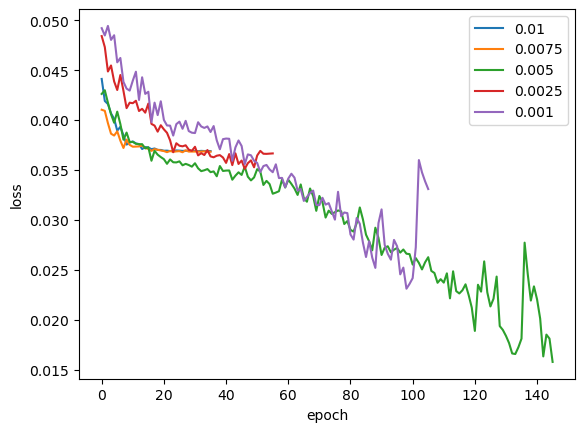

In [124]:
import matplotlib.pyplot as plt

for i in range(len(all_losses)):
    plt.plot(all_losses[i][5:], label = str(lrs[i]))

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

The learning rate of 0.005 seems to do the best job at reducing loss.

### Creating a Validation Function

In [148]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

def validate_model(model, X_test_tensor, y_test_tensor):
    X_test_tensor = X_test_tensor.to(device, non_blocking=True)
    y_test_tensor = y_test_tensor.to(device, non_blocking=True)
    
    with torch.no_grad():
        model.eval()
        y_pred = model.forward(X_test_tensor)
        y_pred = y_pred.cpu().numpy()
        y = y_test_tensor.cpu().numpy()
        
        MSE = mean_squared_error(y, y_pred)
        SMAPE = smape(y, y_pred)
        
    return MSE, SMAPE 

In [127]:
test_model, losses = train_model(X_train_tensor, y_train_tensor, 50, lr = 0.005, num_epochs=500)

Loss change last 10 iterations: 0.9999995560572577
Loss change last 10 iterations: 0.1456879686206337
Loss change last 10 iterations: 0.04851892305152339
Loss change last 10 iterations: 0.023115743530892185
Loss change last 10 iterations: 0.01516187458165652
Loss change last 10 iterations: 0.016499140506789356
Loss change last 10 iterations: 0.02784837983735433
Loss change last 10 iterations: 0.050998436790741786
Loss change last 10 iterations: 0.05193358013744542
Loss change last 10 iterations: 0.08158845953329408
Loss change last 10 iterations: 0.04686486127261236
Loss change last 10 iterations: 0.08873733832752606
Loss change last 10 iterations: 0.054039475327099074
Loss change last 10 iterations: 0.15958771699460472
Loss change last 10 iterations: -0.10082942511971482
Number of epochs and loss: 150 0.01577844551600818


In [140]:
MSE, SMAPE = validate_model(test_model, X_test_tensor, y_test_tensor)

print('The mse and smape are', MSE, SMAPE)

The mse and smape are 0.04708609 13.705479969950247


### Try diffrent loss change and hidden size

In [180]:
MSES = {}
SMAPES = {}

loss_changes = [0.3, 0.2, 0.1, 0.05, 0.01]
hidden_sizes = [100, 200, 300, 400, 500, 600, 700]

device = torch.device("mps")

for loss_change in loss_changes:
    for hidden_size in hidden_sizes:
        if 'model' in globals():
            del model
        
        params = str(hidden_size) + ' ' + str(loss_change)
        print('~' * 40)
        print('The parameters are:', params)
        print('')
        
        model, losses = train_model(X_train_tensor, y_train_tensor, hidden_size = hidden_size, loss_change = loss_change, lr = 0.005, num_epochs=500)
        
        MSE, SMAPE = validate_model(model, X_test_tensor, y_test_tensor)
        
        MSES[params] = MSE
        SMAPES[params] = SMAPE
        
        print('')
        print('The mse and smape are:', MSE, SMAPE)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The parameters are: 100 0.3

Loss change last 5 iterations: 0.9999995107613598
Loss change last 5 iterations: 0.09160342626424733
Number of epochs and loss: 10 0.04335217287361219

The mse and smape are: 0.04565254 12.967475747930836
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The parameters are: 200 0.3

Loss change last 5 iterations: 0.9999995090077225
Loss change last 5 iterations: 0.15074270982882176
Number of epochs and loss: 10 0.039234601766676515

The mse and smape are: 0.04581763 12.78660577140619
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The parameters are: 300 0.3

Loss change last 5 iterations: 0.9999995518724315
Loss change last 5 iterations: 0.08490369630722339
Number of epochs and loss: 10 0.0400381960553696

The mse and smape are: 0.045795232 13.448270895092653
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The parameters are: 400 0.3

Loss change last 5 iterations: 0.9999995588021874
Loss change last 5 iterations: 0.07572458605082444
Numb

In [181]:
SMAPES
{k: v for k, v in sorted(SMAPES.items(), key=lambda item: item[1])}


{'200 0.2': 12.665735809131997,
 '200 0.1': 12.670111376544662,
 '200 0.3': 12.78660577140619,
 '600 0.01': 12.892795476957707,
 '100 0.3': 12.967475747930836,
 '200 0.05': 12.97475002336931,
 '100 0.2': 13.049680613561685,
 '400 0.01': 13.09926629065278,
 '100 0.05': 13.193245156582213,
 '200 0.01': 13.41262877013942,
 '300 0.3': 13.448270895092653,
 '300 0.2': 13.449359672323041,
 '300 0.1': 13.449359672323041,
 '100 0.01': 13.461583863087052,
 '700 0.01': 13.499551005146312,
 '100 0.1': 13.571431415785636,
 '600 0.05': 13.597840883531088,
 '300 0.01': 13.670405937084974,
 '500 0.2': 13.671491528123497,
 '500 0.1': 13.671491528123497,
 '500 0.3': 13.67149829203549,
 '400 0.3': 13.719730224608389,
 '400 0.2': 13.727585925671812,
 '400 0.1': 13.727585925671812,
 '400 0.05': 13.805802271461687,
 '300 0.05': 13.858108003557982,
 '500 0.05': 14.07482918426703,
 '500 0.01': 14.07482918426703,
 '700 0.2': 14.8338795395225,
 '700 0.1': 15.110660362224843,
 '700 0.05': 15.110660362224843,
 '7

In [ ]:
# Hidden size of 200 and loss change of 0.2 seems to be best 

In [183]:
MSES = {}
SMAPES = {}

prs = [0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]

device = torch.device("mps")


for pr in prs:
    if 'model' in globals():
        del model
        
    params = str(pr)
    print('~' * 40)
    print('The parameters are:', params)
    print('')
        
    model, losses = train_model(X_train_tensor, y_train_tensor, hidden_size = 200, loss_change = 0.2, lr = 0.005, num_epochs=500, dropout_pr = pr)
        
    MSE, SMAPE = validate_model(model, X_test_tensor, y_test_tensor)
        
    MSES[params] = MSE
    SMAPES[params] = SMAPE
        
    print('')
    print('The mse and smape are:', MSE, SMAPE)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The parameters are: 0.7

Loss change last 5 iterations: 0.9999994048288923
Loss change last 5 iterations: 0.2530085556789877
Loss change last 5 iterations: 0.09596864687570228
Number of epochs and loss: 15 0.03895922806239813

The mse and smape are: 0.046199284 13.745966104680116
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The parameters are: 0.6

Loss change last 5 iterations: 0.9999994542221237
Loss change last 5 iterations: 0.19335852387516084
Number of epochs and loss: 10 0.042689028170865936

The mse and smape are: 0.045759957 13.411027685260628
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The parameters are: 0.5

Loss change last 5 iterations: 0.9999994894826553
Loss change last 5 iterations: 0.15169392090474243
Number of epochs and loss: 10 0.04169916489941848

The mse and smape are: 0.045653354 13.255101884318373
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The parameters are: 0.4

Loss change last 5 iterations: 0.9999995183221295
Loss change last 

In [ ]:
## pr = 0.2 seems to be best 


## Final paramater choices are lr = 0.005, h = 200, loss change = 0.2 and pr = 0.2